# Homework: Build Your Own Segmentation Model with ConvNeXt

In this assignment, you will build an image segmentation model that uses a provided ConvNeXt layer as the backbone (encoder). Your challenge is to design and implement the segmentation head (decoder) in any way you prefer. This task gives you the flexibility to experiment with different architectural ideas while learning how to repurpose modern convolutional blocks for dense prediction tasks.

## Overview

- **Task:**  
  Use the provided ConvNeXt layer to extract features from the input images, then design your own segmentation decoder to output pixel-wise predictions (segmentation masks).

- **Dataset:**  
  We'll use the Oxford-IIIT Pet dataset (which contains images along with pixel-level segmentation masks). This dataset is easy to download via PyTorch's `torchvision` library.

- **Goal:**  
  Design a segmentation model that can accurately separate the pet from the background (or other semantic regions) in the images. Experiment with different decoder architectures, upsampling techniques, and loss functions.

## Provided ConvNeXt Layer

Below is a simplified ConvNeXt layer that you will use as the building block of your encoder. Feel free to experiment with it or use it as is:

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNeXtLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, padding=3):
        super(ConvNeXtLayer, self).__init__()
        # Depthwise Convolution
        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                stride=stride, padding=padding, groups=in_channels)
        # Layer Normalization (applied over channels)
        self.norm = nn.LayerNorm([in_channels, 1, 1])
        # Activation
        self.activation = nn.GELU()
        # Pointwise Convolution
        self.pwconv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.dwconv(x)
        # Since nn.LayerNorm expects the normalized shape to match the last dimensions,
        # we use a permutation to apply it over channels.
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C]
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)  # [B, C, H, W]
        x = self.activation(x)
        x = self.pwconv(x)
        return x
```


## Your Tasks

### 1. Data Exploration and Preprocessing

- **Download the Dataset:**  
  Use PyTorch's `torchvision.datasets.OxfordIIITPet` to download the dataset with segmentation masks.
- **Visualize the Data:**  
  Explore the images and segmentation masks to understand the data distribution and check for any class imbalances.

#### Example Code to Download & Visualize:


In [ ]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()
])

# Download the Oxford-IIIT Pet dataset with segmentation masks
dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform
)

# Visualize a sample image and its segmentation mask
image, mask = dataset[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.show()

### 2. Model Design and Implementation

Your challenge here is to design the **segmentation decoder** that complements the provided ConvNeXtLayer-based encoder. The key idea is to take the lower-resolution feature maps produced by the encoder and transform them into full-resolution segmentation maps.

#### What You Need to Achieve

- **Input:**  
  The encoder (which you will build by stacking one or more `ConvNeXtLayer`s) takes an image of shape `[B, 3, H, W]` and outputs a feature map. For example, after two layers you might have features of shape `[B, 128, H_enc, W_enc]` where `H_enc` and `W_enc` are downsampled versions of `H` and `W`.

- **Output:**  
  Your segmentation decoder must transform the encoder output into a segmentation mask with shape `[B, num_classes, H, W]`, where `num_classes` is the number of segmentation labels (e.g., 2 for binary segmentation like pet vs. background).

#### Hints for Building Your Decoder

1. **Upsampling:**

   - **Transposed Convolutions:**  
     You can use layers like `nn.ConvTranspose2d` to upsample the feature maps gradually.
   - **Interpolation + Convolution:**  
     Another approach is to upsample using `F.interpolate` (e.g., bilinear interpolation) and follow up with a convolution layer (`nn.Conv2d`) to refine the features.

2. **Skip Connections:**

   - To help recover spatial details lost during downsampling, consider adding skip connections from early encoder layers to corresponding decoder layers.

3. **Layer Organization:**
   - Organize your decoder in stages. For example:
     - **Stage 1:** Upsample features (e.g., from `[B, 128, H_enc, W_enc]` to `[B, 64, H_enc*2, W_enc*2]`).
     - **Stage 2:** Further process and upsample until you reach the original resolution `[B, num_classes, H, W]`.

#### Pseudo-Code Example (Skeleton)

Below is a pseudo-code outline to guide you. **Note:** Do not use this code verbatim—use it as a reference to design your own decoder.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        # Build your encoder using the provided ConvNeXtLayer(s)
        # Example (you can customize this part):
        # self.encoder = nn.Sequential(
        #     ConvNeXtLayer(in_channels=3, out_channels=64),
        #     ConvNeXtLayer(in_channels=64, out_channels=128)
        # )

        # YOUR TASK: Design the decoder
        # Hints:
        # - Your decoder should accept the encoder's output (e.g., [B, 128, H_enc, W_enc])
        # - Use transposed convolutions or F.interpolate + convolution layers to upsample.
        # - Aim to reach an output shape of [B, num_classes, H, W].
        # - Consider using skip connections for better spatial detail.
        #
        # Example skeleton (not a full solution):
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample stage 1
        #     nn.ReLU(inplace=True),
        #     # Add more layers or skip connections as needed
        #     nn.Conv2d(64, num_classes, kernel_size=1)  # Final output layer
        # )

    def forward(self, x):
        # x: [B, 3, H, W]
        features = self.encoder(x)  # e.g., [B, 128, H_enc, W_enc]
        out = self.decoder(features)  # Your decoder should produce [B, num_classes, H, W]

        # If necessary, use interpolation to ensure the output size matches the input size
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out
```


### 3. Training and Evaluation

In this section, you'll set up your training loop, choose appropriate metrics, and evaluate your segmentation model. We'll use:

- **Loss Function:** `CrossEntropyLoss` (suitable for multi-class segmentation).
- **Metrics:**
  - **Pixel Accuracy:** The percentage of correctly predicted pixels.
  - **Intersection-over-Union (IoU):** The ratio of the intersection to the union of the predicted and ground truth regions for each class.

#### Metric Functions

Add these helper functions to compute Pixel Accuracy and Mean IoU:

```python
import torch

def pixel_accuracy(output, target):
    """
    Computes pixel accuracy.

    Parameters:
      output (torch.Tensor): Model predictions of shape [B, num_classes, H, W].
      target (torch.Tensor): Ground truth labels of shape [B, H, W].

    Returns:
      float: Pixel accuracy.
    """
    with torch.no_grad():
        # Get predicted classes from output
        pred = output.argmax(dim=1)
        correct = (pred == target).float()
        acc = correct.sum() / correct.numel()
    return acc

def intersection_over_union(output, target, num_classes):
    """
    Computes Mean Intersection-over-Union (IoU) over all classes.

    Parameters:
      output (torch.Tensor): Model predictions of shape [B, num_classes, H, W].
      target (torch.Tensor): Ground truth labels of shape [B, H, W].
      num_classes (int): Number of segmentation classes.

    Returns:
      float: Mean IoU over all classes.
    """
    with torch.no_grad():
        pred = output.argmax(dim=1)
        ious = []
        for cls in range(num_classes):
            pred_inds = (pred == cls)
            target_inds = (target == cls)
            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            if union == 0:
                ious.append(torch.tensor(1.0))  # If no ground truth for class, count IoU as 1.
            else:
                ious.append(intersection / union)
        mean_iou = torch.mean(torch.stack(ious))
    return mean_iou
```


# Training Loop Example

Below is an example training loop that uses the above metrics. This loop trains your model for a set number of epochs, prints the loss for each epoch, and evaluates the Pixel Accuracy and Mean IoU after each epoch.


## Deliverables

Please ensure that your final submission includes **all the components in a single Jupyter Notebook**. Your notebook should be well-organized, with clear headings, comments, and markdown cells that explain your work. Specifically, your submission should include:

1. **Data Exploration and Preprocessing**

   - Code to download and load the Oxford-IIIT Pet dataset.
   - Visualizations of sample images and their corresponding segmentation masks.
   - A brief analysis discussing any observations from the data (e.g., class imbalances, noise, etc.).

2. **Model Design and Implementation**

   - Your implementation of an encoder that uses the provided `ConvNeXtLayer`.
   - Your custom segmentation decoder design. Be sure to clearly explain:
     - The input and output shapes (e.g., encoder output of shape `[B, 128, H_enc, W_enc]` and desired decoder output of `[B, num_classes, H, W]`).
     - The architectural choices (e.g., upsampling methods, any skip connections, etc.).
     - How your design transforms low-resolution feature maps back to full-resolution segmentation maps.

3. **Training and Evaluation**

   - A complete training loop with:
     - The use of `CrossEntropyLoss` as your loss function.
     - An optimizer (e.g., Adam) and any learning rate adjustments.
   - Code to compute evaluation metrics:
     - **Pixel Accuracy**: The percentage of correctly predicted pixels.
     - **Intersection-over-Union (IoU)**: Mean IoU across classes.
   - Visualizations or printed outputs that demonstrate model performance over epochs.
   - A brief discussion of the results (e.g., trends in loss, pixel accuracy, and IoU).

4. **Overall Notebook Structure**
   - Clear organization with sections separated by markdown headings.
   - Inline comments explaining key parts of your code.
   - A summary or conclusion section reflecting on your experiments and results.

---

### Submission Instructions

- **Format:** Submit your work as a single Jupyter Notebook (e.g., `segmentation_homework.ipynb`).
- **Content:** The notebook must include all the code, visualizations, and explanations outlined above.


In [16]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()
])

# Download the Oxford-IIIT Pet dataset with segmentation masks
dataset = torchvision.datasets.OxfordIIITPet(
    root='data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=target_transform
)

In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(EncoderBlock, self).__init__()
        self.downsample = downsample

        self.conv = ConvNeXtLayer(in_channels, out_channels)

        if downsample:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        if self.downsample:
            # Return both downsampled and original for skip connections
            return self.pool(x), x
        return x, x

# Decoder block for upsampling


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=True):
        super(DecoderBlock, self).__init__()

        # For upsampling path, the input to the upsample is just the bottleneck features
        # not the concatenated ones
        if upsample:
            self.upsample = nn.ConvTranspose2d(
                in_channels // 2, in_channels // 4, kernel_size=2, stride=2)
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels // 4 + in_channels // 2,
                          out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.upsample = nn.Identity()
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if skip is not None:
            # Ensure the spatial dimensions match
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(
                    x, size=skip.shape[2:], mode='bilinear', align_corners=False)

            # Concatenate along channel dimension
            x = torch.cat([x, skip], dim=1)

        return self.conv(x)

# Complete Segmentation Model with ConvNeXt Encoder and UNet-style Decoder


class SegmentationModel(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(SegmentationModel, self).__init__()

        # Encoder pathway (downsampling)
        self.enc1 = EncoderBlock(
            in_channels, 64, downsample=True)     # 64x112x112
        self.enc2 = EncoderBlock(
            64, 128, downsample=True)             # 128x56x56
        self.enc3 = EncoderBlock(
            128, 256, downsample=True)            # 256x28x28
        self.enc4 = EncoderBlock(
            256, 512, downsample=True)            # 512x14x14

        # Bridge
        self.bridge = ConvNeXtLayer(
            512, 512)                          # 512x14x14

        # Decoder pathway (upsampling with skip connections)
        # Each decoder takes the upsampled features and concatenates with skip connection
        self.up4 = nn.ConvTranspose2d(
            512, 256, kernel_size=2, stride=2)  # 256x28x28
        self.dec4 = nn.Sequential(
            nn.Conv2d(256 + 512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(
            256, 128, kernel_size=2, stride=2)  # 128x56x56
        self.dec3 = nn.Sequential(
            nn.Conv2d(128 + 256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(
            128, 64, kernel_size=2, stride=2)   # 64x112x112
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(
            64, 32, kernel_size=2, stride=2)    # 32x224x224
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Final layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder pathway with skip connections
        # 64x112x112
        x, skip1 = self.enc1(x)
        # 128x56x56
        x, skip2 = self.enc2(x)
        # 256x28x28
        x, skip3 = self.enc3(x)
        # 512x14x14
        x, skip4 = self.enc4(x)

        # Bridge
        # 512x14x14
        x = self.bridge(x)

        # Decoder pathway using skip connections
        # 256x28x28
        x = self.up4(x)
        # (256+512)x28x28
        x = torch.cat([x, skip4], dim=1)
        # 256x28x28
        x = self.dec4(x)

        # 128x56x56
        x = self.up3(x)
        # (128+256)x56x56
        x = torch.cat([x, skip3], dim=1)
        # 128x56x56
        x = self.dec3(x)

        # 64x112x112
        x = self.up2(x)
        # (64+128)x112x112
        x = torch.cat([x, skip2], dim=1)
        # 64x112x112
        x = self.dec2(x)

        # 32x224x224
        x = self.up1(x)
        # (32+64)x224x224
        x = torch.cat([x, skip1], dim=1)
        # 32x224x224
        x = self.dec1(x)

        # Final layer to get segmentation map
        # num_classesx224x224
        x = self.final(x)

        return x

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# Create data loaders
batch_size = 8
train_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop


def train_model():
    # For tracking metrics
    history = {
        'train_loss': [],
        'pixel_accuracy': [],
        'iou': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_pixel_acc = 0.0
        epoch_iou = 0.0

        # Progress bar for training
        loop = tqdm(enumerate(train_loader), total=len(
            train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (images, masks) in loop:
            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)

            # Convert masks to class indices
            # Assuming masks has shape [B, 1, H, W] and values in range [0, 1, 2]
            # Change to [B, H, W] with class indices
            masks = masks.squeeze(1).long()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Calculate metrics
            predictions = torch.argmax(outputs, dim=1)

            # Pixel accuracy
            correct_pixels = (predictions == masks).sum().item()
            total_pixels = masks.numel()
            batch_pixel_acc = correct_pixels / total_pixels
            epoch_pixel_acc += batch_pixel_acc

            # IoU (Jaccard Index)
            batch_iou = 0.0
            num_classes = outputs.size(1)

            for cls in range(num_classes):
                pred_mask = (predictions == cls)
                true_mask = (masks == cls)

                intersection = (pred_mask & true_mask).sum().float().item()
                union = (pred_mask | true_mask).sum().float().item()

                if union > 0:
                    batch_iou += intersection / union

            # Average IoU across classes
            batch_iou /= num_classes
            epoch_iou += batch_iou

            # Update progress bar with current metrics
            loop.set_postfix(
                loss=loss.item(),
                pixel_acc=batch_pixel_acc,
                iou=batch_iou
            )

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_pixel_acc = epoch_pixel_acc / len(train_loader)
        epoch_iou = epoch_iou / len(train_loader)

        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['pixel_accuracy'].append(epoch_pixel_acc)
        history['iou'].append(epoch_iou)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Pixel Accuracy: {epoch_pixel_acc:.4f}, IoU: {epoch_iou:.4f}")

    return history


# Run training
history = train_model()

# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(history['pixel_accuracy'])
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['iou'])
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.tight_layout()
plt.show()

# Define evaluation function


def evaluate_model(model, dataloader):
    model.eval()
    total_pixel_acc = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.squeeze(1).long()

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Pixel accuracy
            correct_pixels = (predictions == masks).sum().item()
            total_pixels = masks.numel()
            batch_pixel_acc = correct_pixels / total_pixels
            total_pixel_acc += batch_pixel_acc

            # IoU
            batch_iou = 0.0
            num_classes = outputs.size(1)

            for cls in range(num_classes):
                pred_mask = (predictions == cls)
                true_mask = (masks == cls)

                intersection = (pred_mask & true_mask).sum().float().item()
                union = (pred_mask | true_mask).sum().float().item()

                if union > 0:
                    batch_iou += intersection / union

            batch_iou /= num_classes
            total_iou += batch_iou

    # Calculate average metrics
    avg_pixel_acc = total_pixel_acc / len(dataloader)
    avg_iou = total_iou / len(dataloader)

    return avg_pixel_acc, avg_iou

/opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <8E6D6BF5-9658-33B9-9D3C-DF587B2F99E7> /opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anacond

KeyboardInterrupt: 

/opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <8E6D6BF5-9658-33B9-9D3C-DF587B2F99E7> /opt/anaconda3/envs/python-3-11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
Mask shape: torch.Size([1, 224, 224])
Mask min/max values: 0.003921568859368563, 0.0117647061124444
Prediction shape: torch.Size([224, 224])
Prediction unique values: tensor([2])


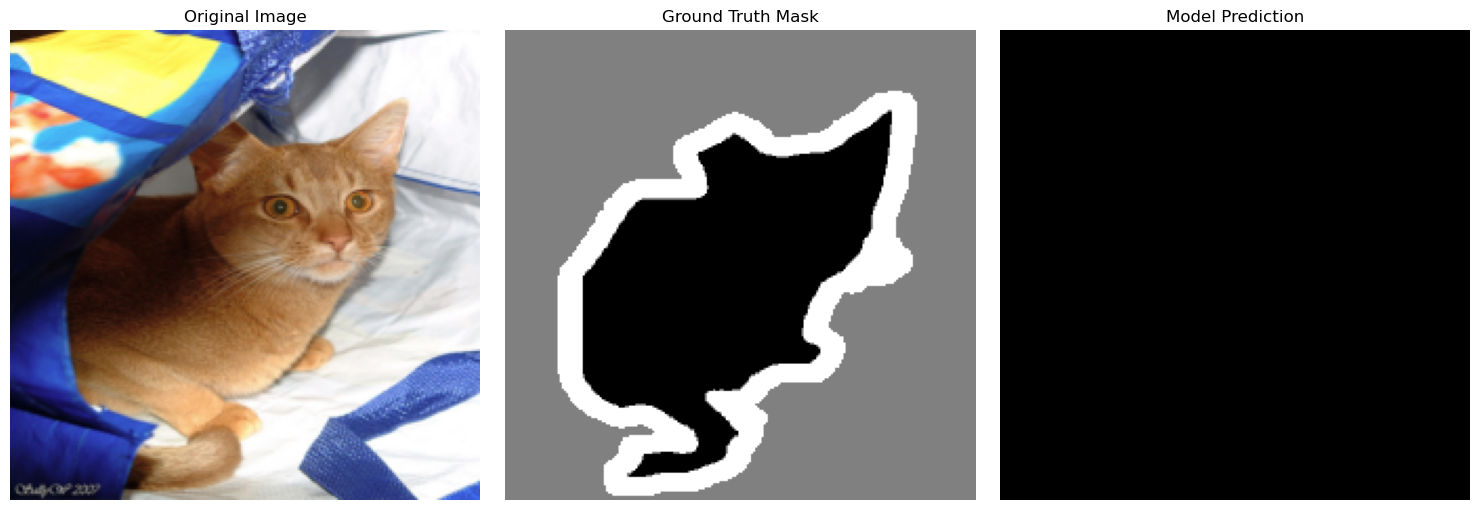

In [ ]:
def visualize_single_prediction(model, dataset, index=0):
    """
    Pass a single image through the model and visualize the results
    with grayscale masks

    Args:
        model: The segmentation model
        dataset: The dataset containing images and masks
        index: Index of the image to visualize (default=0)
    """
    # Set model to evaluation mode
    model.eval()
    device = next(model.parameters()).device

    # Get a single image and mask
    image, mask = dataset[index]

    # Add batch dimension for the model
    image = image.unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1)

    # Move tensors to CPU for visualization
    image = image.squeeze(0).cpu()
    prediction = prediction.squeeze(0).cpu()

    # Convert tensors to numpy for display
    image_np = image.permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
    mask_np = mask.squeeze().numpy()
    pred_np = prediction.numpy()

    print(pred_np)
    # Print some basic info about the values
    print(f"Mask shape: {mask.shape}")
    print(f"Mask min/max values: {mask.min().item()}, {mask.max().item()}")
    print(f"Prediction shape: {prediction.shape}")
    print(f"Prediction unique values: {torch.unique(prediction)}")

    # Display the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Model Prediction')
    plt.imshow(pred_np, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
# Just pass one image through the model and display the results
visualize_single_prediction(model, dataset, index=0)